In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform
import skimage as ski
import time
import imageio


In [7]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
from inverse_compositional_algorithm import inverse_compositional_algorithm, robust_inverse_compositional_algorithm, pyramidal_inverse_compositional_algorithm
import configuration_handler as cfh
import image_optimisation as io
import transformation as tr
import inverse_compositional_algorithm_keras as ica_keras

We create a configuration file with the meta parameters for the algorithm. 

In [8]:
# reading the parameters from the configuration file
params = cfh.read_config_file("config.ini")
params_rica = params["robust_inverse_compositional_algorithm"]
params_pica = params["pyramidal_inverse_compositional_algorithm"]

## Performing some unit tests

For the sake of debugging the implementation with keras and tensorflow, we perform some tests on the well known cases.

In [9]:
# A dataset with simple transformations for unit testing
dataset_tu = {
    "rubber_whale_tr": {
        "original_filename": "rubber_whale.png",
        "transformed_filename": "rubber_whale_tr.png",
        "transformation_type": tr.TransformType.TRANSLATION,
        "gt": [10, 5] # [tx,ty]
    },
    "rubber_whale_rt": {
        "original_filename": "rubber_whale.png",
        "transformed_filename": "rubber_whale_rt.png",
        "transformation_type": tr.TransformType.EUCLIDEAN,
        "gt": [0., 0., -0.1] # [tx,ty,theta] -> ROTATION, theta in radians and counterclockwise
    },
    "rubber_whale_eu": {
        "original_filename": "rubber_whale.png",
        "transformed_filename": "rubber_whale_eu.png",
        "transformation_type": tr.TransformType.EUCLIDEAN,
        "gt": [10., 5., -0.1] # [tx,ty,theta] -> ROTATION, theta in radians and counterclockwise
    },
    "rubber_whale_zo": {
        "original_filename": "rubber_whale.png",
        "transformed_filename": "rubber_whale_zo.png",
        "transformation_type": tr.TransformType.SIMILARITY,
        "gt": [0., 0., -0.1, 0.] # [tx,ty,a,b] -> ZOOM
    }
}

In [10]:
print("The current directory is: ", os.getcwd())
image_path = os.path.join(os.getcwd(), "data")

The current directory is:  c:\Users\FournigaultM\git\computational_astro\inverse_compositional_algorithm\test


------ Inverse Compositional Algorithm on dataset_tu ------
Processing dataset image:  rubber_whale_tr


C:\Users\FournigaultM\AppData\Local\Temp\ipykernel_39236\1519841131.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_image = imageio.imread(os.path.join(image_path, sample["original_filename"]))
C:\Users\FournigaultM\AppData\Local\Temp\ipykernel_39236\1519841131.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  transformed_image = imageio.imread(os.path.join(image_path, sample["transformed_filename"]))


	Original Filename:  rubber_whale.png
	Transformed Filename:  rubber_whale_tr.png
With Meta parameters:  {'TOL': 0.001, 'transform_type': <TransformType.EUCLIDEAN: 2>, 'pyramid_levels': 3, 'nu': 0.5, 'robust_type': <RobustErrorFunctionType.CHARBONNIER: 4>, 'lambda': 0.0, 'verbose': True}
For transformation type:  TransformType.TRANSLATION
shape of p[scale]:  (1, 2)
--- J shape:  (97, 146, 4)
dp shape:  (1, 2)
error shape:  ()
dp shape:  (1, 2)
error shape:  ()
dp shape:  (1, 2)
error shape:  ()
dp shape:  (1, 2)
error shape:  ()
dp shape:  (1, 2)
error shape:  ()
dp shape:  (1, 2)
error shape:  ()
dp shape:  (1, 2)
error shape:  ()
dp shape:  (1, 2)
error shape:  ()
dp shape:  (1, 2)
error shape:  ()
dp shape:  (1, 2)
error shape:  ()
dp shape:  (1, 2)
error shape:  ()
dp shape:  (1, 2)
error shape:  ()
dp shape:  (1, 2)
error shape:  ()
dp shape:  (1, 2)
error shape:  ()
dp shape:  (1, 2)
error shape:  ()
dp shape:  (1, 2)
error shape:  ()
dp shape:  (1, 2)
error shape:  ()
dp shape: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


dp shape:  (1, 2)
error shape:  ()
Original parameters:  [np.float64(-10.0), np.float64(-5.0)]
Estimated parameters:  tf.Tensor([[-99.70586  90.46583]], shape=(1, 2), dtype=float32)


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Attempting to slice scalar input. [Op:StridedSlice] name: strided_slice/

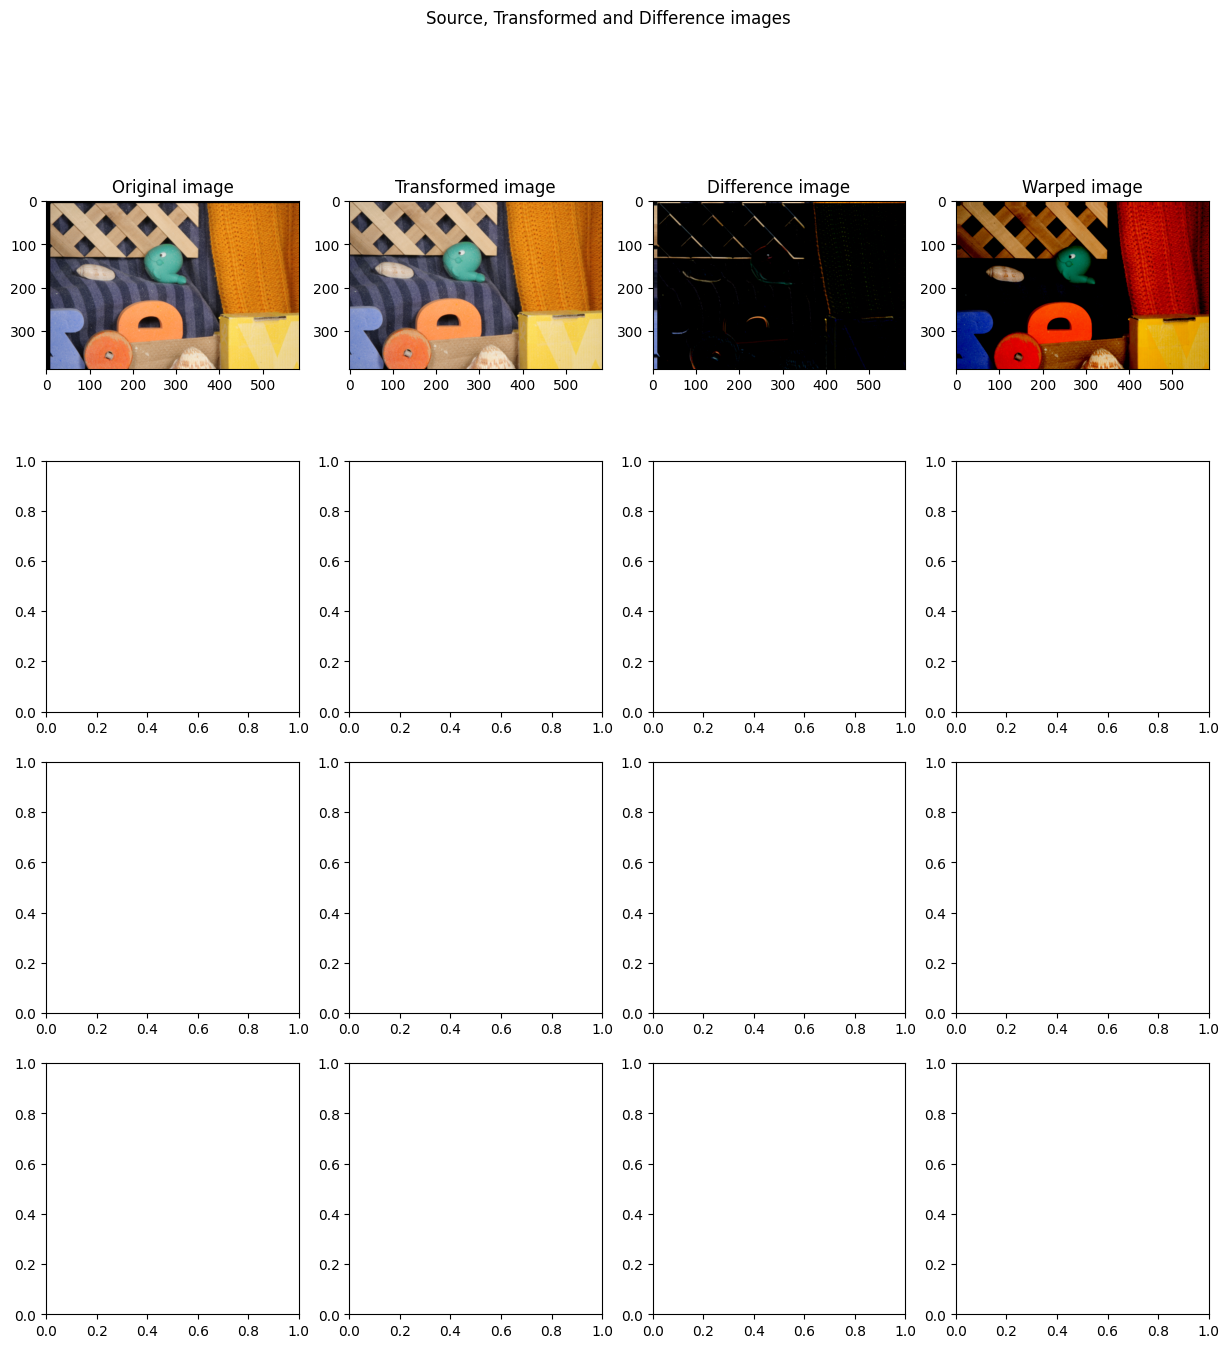

In [11]:
print("------ Inverse Compositional Algorithm on dataset_tu ------")
fig, axs = plt.subplots(4, 4, figsize=(15,15))
fig.suptitle("Source, Transformed and Difference images")
i = 0

for sample_key, sample in dataset_tu.items():
    print("Processing dataset image: ", sample_key)
    original_image = imageio.imread(os.path.join(image_path, sample["original_filename"]))
    transformed_image = imageio.imread(os.path.join(image_path, sample["transformed_filename"]))
    print("\tOriginal Filename: ", sample["original_filename"])
    print("\tTransformed Filename: ", sample["transformed_filename"])
    transformation_type = sample["transformation_type"]
    gt = sample["gt"]
    ofilename = sample_key + ".png"
    # We put everything upside down, as we want the transformed one as I1 and the original one as I2, 
    # in that case we take the inverse of the transformation
    sample["original_image"] = transformed_image
    sample["transformed_image"] = original_image
    gti=tr.matrix2params(np.linalg.inv(tr.params2matrix(gt, transformation_type)), transformation_type)
    sample["gt"] = gti
    original_image = sample["original_image"]
    transformed_image = sample["transformed_image"]
    transformation_type = sample["transformation_type"]
    p = np.zeros(transformation_type.nparams())
    gt = sample["gt"]
    print("With Meta parameters: ", params_pica)
    print("For transformation type: ", transformation_type)
    pica = ica_keras.PyramidalInverseCompositional(
            transformation_type, 
            nscales=params_pica["pyramid_levels"], 
            nu=params_pica["nu"],
            TOL=params_pica["TOL"],
            robust_type=params_pica["robust_type"],
            lambda_=params_pica["lambda"],
            nanifoutside=True,
            delta=10,
            verbose=params_pica["verbose"]
        )

    original_batch = tf.expand_dims(original_image, axis=0)  # (1, H, W, C)
    transformed_batch = tf.expand_dims(transformed_image, axis=0)  # (1, H, W, C)
    p, error, DI, Iw = pica(inputs=[original_batch, transformed_batch])
    
    # display the image
    axs[i][0].imshow(ski.exposure.rescale_intensity(original_image))
    axs[i][0].set_title("Original image")
    # axs[i][1].imshow(source_image)
    # axs[i][1].set_title("Source image")
    axs[i][1].imshow(ski.exposure.rescale_intensity(transformed_image))
    axs[i][1].set_title("Transformed image")
    # img = axs[i][2].imshow(DI, cmap="gray", vmin=0, vmax=np.max(np.max(DI)))
    # fig.colorbar(img, ax=axs[i][2])
    axs[i][2].imshow(ski.exposure.rescale_intensity(np.nan_to_num(DI[0], copy=True)))
    axs[i][2].set_title("Difference image")
    axs[i][3].imshow(ski.exposure.rescale_intensity(np.nan_to_num(Iw[0], copy=True)))
    axs[i][3].set_title("Warped image")
    i += 1
    print("Original parameters: ", gt)
    print("Estimated parameters: ", p[0])
    print("Error on estimation: ", error)

plt.show()


## Performing evaluation tests

In [ ]:

# Reuse the RobustInverseCompositional and PyramidalInverseCompositional layers from previous code

class TFDSEvaluator:
    def __init__(self, img_size=(256, 256)):
        self.img_size = img_size
        self.models = {
            'Single-scale': RobustInverseCompositional(
                transform_type=TransformType.AFFINE,
                TOL=1e-5,
                robust_type=RobustErrorFunctionType.HUBER,
                lambda_=0.1,
                max_iter=50
            ),
            'Pyramidal': PyramidalInverseCompositional(
                nscales=3,
                nu=0.5,
                transform_type=TransformType.AFFINE,
                TOL=1e-5,
                robust_type=RobustErrorFunctionType.HUBER,
                lambda_=0.1,
                max_iter=50
            )
        }
        
        # Load dataset
        self.dataset = self.load_dataset()

    def load_dataset(self):
        """Load horses_or_humans dataset from TFDS"""
        ds = tfds.load('horses_or_humans', split='test', shuffle_files=True)
        
        def preprocess(example):
            img = tf.image.convert_image_dtype(example['image'], tf.float32)
            img = tf.image.resize(img, self.img_size)
            return img.numpy()  # Convert to numpy for scipy transformations
        
        return [preprocess(x) for x in ds]

    def generate_affine_params(self):
        """Generate random affine transformation parameters"""
        return {
            'scale': np.random.uniform(0.7, 1.3, 2),
            'rotation': np.random.uniform(-np.pi/6, np.pi/6),
            'shear': np.random.uniform(-0.3, 0.3),
            'translation': np.random.uniform(-50, 50, 2)
        }

    def create_affine_matrix(self, params):
        """Create affine transformation matrix from parameters"""
        scale_matrix = np.array([[params['scale'][0], 0, 0],
                                [0, params['scale'][1], 0]])
        
        rotation_matrix = np.array([[np.cos(params['rotation']), -np.sin(params['rotation']), 0],
                                   [np.sin(params['rotation']), np.cos(params['rotation']), 0]])
        
        shear_matrix = np.array([[1, params['shear'], 0],
                                [0, 1, 0]])
        
        translation_matrix = np.array([[1, 0, params['translation'][0]],
                                      [0, 1, params['translation'][1]]])
        
        # Combine transformations: scale -> rotate -> shear -> translate
        matrix = translation_matrix @ shear_matrix @ rotation_matrix @ scale_matrix
        return matrix[:2, :]

    def apply_affine_transform(self, img, matrix):
        """Apply affine transform using scipy"""
        transformed = np.zeros_like(img)
        for c in range(3):
            transformed[..., c] = affine_transform(
                img[..., c],
                matrix=matrix[:, :2],
                offset=matrix[:, 2],
                order=3,
                mode='constant',
                cval=0.0
            )
        return transformed

    def evaluate(self, num_samples=50):
        results = {name: {'mse': [], 'mae': [], 'epe': [], 'time': []} 
                  for name in self.models}
        
        for i in range(num_samples):
            # Select random image
            img1 = self.dataset[np.random.randint(len(self.dataset))]
            
            # Generate random transformation
            params = self.generate_affine_params()
            matrix = self.create_affine_matrix(params)
            
            # Apply transformation
            img2 = self.apply_affine_transform(img1, matrix)
            
            # Convert to tensors
            I1 = tf.expand_dims(tf.convert_to_tensor(img1, tf.float32), 0)
            I2 = tf.expand_dims(tf.convert_to_tensor(img2, tf.float32), 0)
            
            # Ground truth parameters (flattened affine matrix)
            true_params = matrix.flatten()[:6]

            for name, model in self.models.items():
                start_time = time.time()
                
                # Estimate transformation
                p_pred, error, DI, Iw = model([I1, I2])
                params_pred = p_pred.numpy()[0]
                
                # Calculate parameter errors
                mse = np.mean((params_pred - true_params)**2)
                mae = np.mean(np.abs(params_pred - true_params))
                
                # Calculate endpoint error (EPE)
                pred_flow = self.params_to_flow(params_pred)
                true_flow = self.params_to_flow(true_params)
                epe = np.mean(np.sqrt(np.sum((pred_flow - true_flow)**2, axis=-1)))
                
                # Store results
                results[name]['mse'].append(mse)
                results[name]['mae'].append(mae)
                results[name]['epe'].append(epe)
                results[name]['time'].append(time.time() - start_time)
                
        return results

    def params_to_flow(self, params):
        """Convert affine parameters to flow field"""
        h, w = self.img_size
        matrix = params.reshape(2, 3)
        
        x = np.linspace(0, w-1, w)
        y = np.linspace(0, h-1, h)
        xx, yy = np.meshgrid(x, y)
        ones = np.ones_like(xx)
        coords = np.stack([xx, yy, ones], axis=0)
        
        transformed = np.tensordot(matrix, coords, axes=([1], [0]))
        flow = np.moveaxis(transformed, 0, -1) - np.stack([xx, yy], axis=-1)
        return flow

    def plot_results(self, results):
        metrics = ['mse', 'mae', 'epe', 'time']
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        
        for i, metric in enumerate(metrics):
            ax = axs[i//2, i%2]
            for name in self.models:
                ax.plot(results[name][metric], label=name)
            ax.set_title(f'{metric.upper()} Comparison')
            ax.set_xlabel('Sample Index')
            ax.set_ylabel(metric.upper())
            ax.legend()
            ax.grid(True)
            
        plt.tight_layout()
        plt.show()




In [ ]:
# Run evaluation
evaluator = TFDSEvaluator()
results = evaluator.evaluate(num_samples=50)
evaluator.plot_results(results)


In [ ]:
# Print summary statistics
print("Average Metrics:")
for name in evaluator.models:
    print(f"\n{name}:")
    for metric in ['mse', 'mae', 'epe', 'time']:
        avg = np.mean(results[name][metric])
        print(f"  {metric.upper()}: {avg:.4f}")